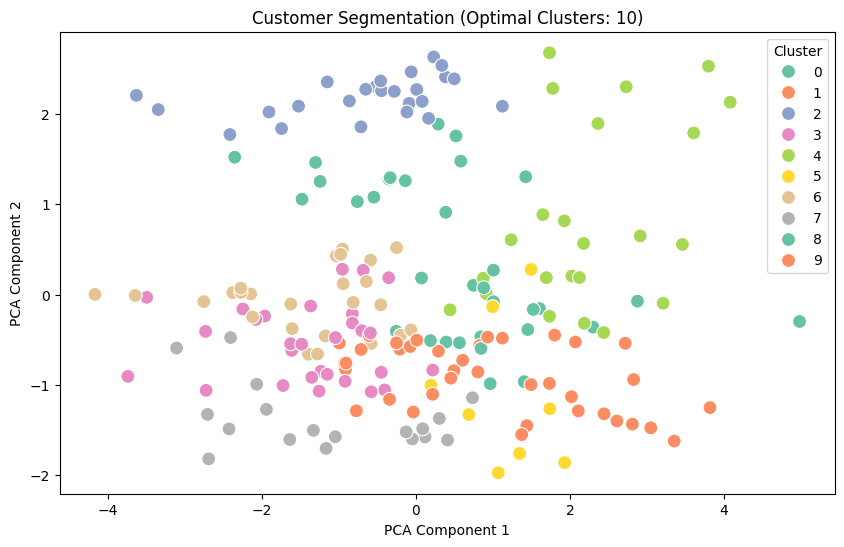

Clustering Results:
   n_clusters  DB_Index  Silhouette_Score
0           2  1.699443          0.209412
1           3  1.501360          0.228985
2           4  1.376703          0.266714
3           5  1.375637          0.255285
4           6  1.335656          0.251783
5           7  1.426760          0.238005
6           8  1.314742          0.267086
7           9  1.340830          0.262946
8          10  1.301697          0.261295


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

# Convert to datetime
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Extract year and month
customers['SignupYear'] = customers['SignupDate'].dt.year
transactions['TransactionMonth'] = transactions['TransactionDate'].dt.month
transactions['YearMonth'] = transactions['TransactionDate'].dt.to_period('M')

# Aggregate transaction data per customer
transactions_agg = transactions.groupby("CustomerID").agg(
    total_spending=("TotalValue", "sum"),
    transaction_count=("TransactionID", "count"),
    avg_transaction_value=("TotalValue", "mean"),
    total_quantity=("Quantity", "sum"),
).reset_index()

# Merge with customer profile data
customer_data = customers.merge(transactions_agg, on="CustomerID", how="left")

# Fill missing values (if a customer has no transactions)
customer_data = customer_data.fillna(0)

# Encode categorical variables (e.g., Region)
customer_data = pd.get_dummies(customer_data, columns=["Region"], drop_first=True)

# Select features for clustering
features = ["total_spending", "transaction_count", "avg_transaction_value", "total_quantity", "SignupYear"]
features.extend([col for col in customer_data.columns if col.startswith("Region_")])
X = customer_data[features]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform clustering for 2-10 clusters
results = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)

    # Compute Davies-Bouldin Index
    db_index = davies_bouldin_score(X_scaled, cluster_labels)

    # Compute silhouette score
    sil_score = silhouette_score(X_scaled, cluster_labels)

    # Append results
    results.append({"n_clusters": n_clusters, "DB_Index": db_index, "Silhouette_Score": sil_score})

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

# Optimal number of clusters (lowest DB Index)
optimal_clusters = results_df.loc[results_df["DB_Index"].idxmin(), "n_clusters"]

# Perform clustering with optimal clusters
final_kmeans = KMeans(n_clusters=int(optimal_clusters), random_state=42)
customer_data["Cluster"] = final_kmeans.fit_predict(X_scaled)

# Visualization using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=customer_data["Cluster"], palette="Set2", s=100)
plt.title(f"Customer Segmentation (Optimal Clusters: {int(optimal_clusters)})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

# Display cluster metrics
print("Clustering Results:")
print(results_df)